# **Analysis of "COVID-19 pneumonia and the subsequent risk of acquiring pulmonary tuberculosis"**
Note that if you cannot run R in your jupyter environment, please access the following: https://drive.google.com/file/d/1fvJeXZShPmUSQiOD9IKO3hzTOzDflXl0/view?usp=sharing

# **Must read**

We recieved 2 large files from the NHSO: OP and IP databases. Both of them could be linked using hashed citizen ID. However, they could indirectly identify a person from some variable, eg, date of birth, date of service, etc. We thus de-identified them as the data provided.

The data provided, the dynamic cohort, were deidentified and hashed for personal data protection. The genhash could only link individuals in the dataframe. The dataframe could not identify any person and could not be traced back. Only necessary variables were retained. Raw data can be shared upon written request to the corresponding author.

### **Data dictionary**

**genhash** [chr]: *de-identified ID*, ie,"4b5630ee914e848e8d07221556b0a2fb", "c01f179e4b57ab8bd9de309e6d576c48"

**sev** [chr]: *COVID-19 status*: "Population control", "Negative control", "Asymptomatic", "Symptomatic non-pneumonia", "Pneumonia", "Severe pneumonia"

**sevm** [fct]: *COVID-19 status used for analysis (pneumonia and severe pneumonia were combined)*: "Population control", "Negative control", "Asymptomatic", "Symptomatic non-pneumonia", "Pneumonia"

**coviddeath** [lgl]: *Status at discharge for hospitalised patients with COVID-19* 
- FALSE: survive
- TRUE: dead
- NA: no COVID-19

**LOS** [int]: *Length of hospital stay* (days from COVID-19 detection to discharge with recovery/death, all refered hospital data were summed up)
- NA: no COVID-19

**timetoevent** [dbl]: *Days from starting follow up for each individual to TB detection or censor* (censor: any cause of death/COVID-19 status changed/end of study)

**tb** [lgl]: *TB detection at time to event*
- FALSE: not detected
- TRUE: detected

**sex** [lgl]: *Male or not*
- FALSE: Female
- TRUE: Male

**age **[fct]: *Age group*: 18-40, 41-60, >60

**hiv** [lgl]: *HIV infection* (patients in HIV registration)
- FALSE: not infected
- TRUE: infected

**dm** [lgl]: *Underlying Diabetes mellitus* (patients in DM registration)
- FALSE: no DM
- TRUE: DM

**cancer** [lgl]: *Underlying any cancer* (patients in cancer registration)
- FALSE: no cancer
- TRUE: any cancer

**copd** [lgl]: *Underlying chronic obstructive Chronic Obstructive Pulmonary Disease* (patients in COPD registration) 
- FALSE: no COPD
- TRUE: COPD

**recv** [lgl]: *COVID-19 reinfection only for the patients who had COVID-19 before October 1, 2021*
- FALSE: no reinfection
- TRUE: reinfection

**timetorecv**  [dbl]: *days from the first COVID-19 infection detected to the second COVID-19 infection detected* 

NA for individuals without COVID-19 reinfection

**Preparation**

Install libraries for data analysis

In [ ]:
install.packages("tidyverse")
install.packages("readxl")
install.packages("stringr")
install.packages("ggpubr")
install.packages("survminer")
install.packages("epiDisplay")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SparseM’, ‘MatrixModels’, ‘sp’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘lme4’, ‘Rcpp’, ‘corrplot’, ‘car’, ‘ggrepel’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘markdown’, ‘RCurl’, ‘png’, ‘jpeg’, ‘exactRankTests’, ‘mvtnorm’, ‘KMsurv’, ‘zoo’, ‘km.ci’, ‘xtable’, ‘gridtext’, ‘maxstat’, ‘survMisc’, ‘ggtext’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Import the essential libraries

In [ ]:
library(tidyverse)
library(data.table)
library(readxl)
library(lubridate)
library(stringr)
library(survminer)
library(epiDisplay)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: ggpubr

Loading required pa

**Import data**

Note that we import data from an online source that can be expired. Data will be re-uploaded upon written request to the corresponding author.

*import claim data*

In [ ]:
temp <- tempfile()
download.file("https://drive.google.com/uc?id=1rzkpfRRtyXNFzpUgAZZ-AySs4TNITOFf&authuser=0&export=download&confirm=t&uuid=2e032824-752e-486f-be25-9552dd5eb829", temp)
hhr<-readRDS(temp)

**Descriptive information**

*Number of individuals in the dynamic cohort*

Note that each individual could be in more than one COVID-19 status, for example, population control -> negative control -> asymptomatic COVID-19

In [ ]:
nrow(unique(hhr,by="genhash"))

[1] 4241201

*Person-years contributed by each exposured group*

In [ ]:
fig2<-summary(pyears(Surv(timetoevent/365, tb) ~ sev,data = hhr,scale = 1))
print("====")
round(fig2$pyear,0)
print(paste0("Sum of all:", sum(round(fig2$pyear,0))))

Call: pyears(formula = Surv(timetoevent/365, tb) ~ sev, data = hhr, 
    scale = 1)

number of observations = 4298873

            sev                 N      Events       Time      
--------------------------- --------- -------- -------------- 
       Asymptomatic            54286      23      34251.4192 
     Negative control         384423     170     227917.6219 
         Pneumonia             23799      69      13916.3479 
    Population control       3818612    2423    3108224.1560 
     Severe pneumonia            818       6        243.2932 
 Symptomatic non-pneumonia     16935      20      10325.1836 
[1] "===="


sev
             Asymptomatic          Negative control                 Pneumonia 
                    34251                    227918                     13916 
       Population control          Severe pneumonia Symptomatic non-pneumonia 
                  3108224                       243                     10325

[1] "Sum of all:3394877"


*There were only 6 events in the severe pneumonia group, so we combined it with the pneumonia group.*

*Person-years contributed by each exposure group* **(for analysis)**

In [ ]:
fig2<-summary(pyears(Surv(timetoevent/365, tb) ~ sevm,data = hhr,scale = 1))
print("====")
round(fig2$pyear,0)
print(paste0("Sum of all:", sum(round(fig2$pyear,0))))

Call: pyears(formula = Surv(timetoevent/365, tb) ~ sevm, data = hhr, 
    scale = 1)

number of observations = 4298873

           sevm                 N      Events      Time     
--------------------------- --------- -------- ------------ 
    Population control       3818612    2423    3108224.16 
     Negative control         384423     170     227917.62 
       Asymptomatic            54286      23      34251.42 
 Symptomatic non-pneumonia     16935      20      10325.18 
         Pneumonia             24617      75      14159.64 
[1] "===="


sevm
       Population control          Negative control              Asymptomatic 
                  3108224                    227918                     34251 
Symptomatic non-pneumonia                 Pneumonia 
                    10325                     14160

[1] "Sum of all:3394878"


**Demographic information**

*Age could not be shown in this file; some individuals with extreme ages can be identified.*

In [ ]:
#tapply(hhr$age, hhr$sev, summary)

Here is the result.

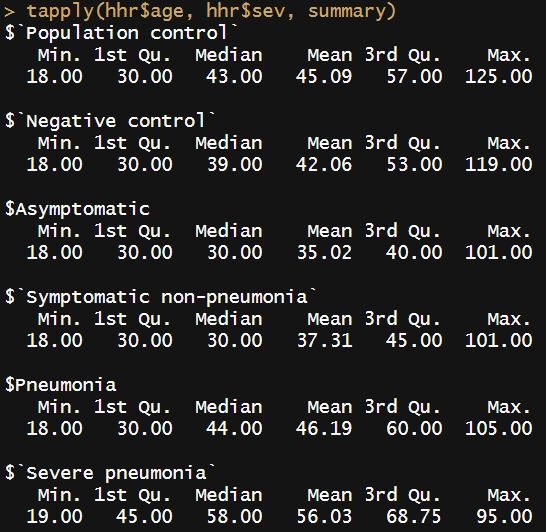

*Sex (person-years contributed)*

In [ ]:
summary(pyears(Surv(timetoevent/365, tb) ~ sevm+sex,data = hhr,scale = 1))

Call: pyears(formula = Surv(timetoevent/365, tb) ~ sevm + sex, data = hhr, 
    scale = 1)

number of observations = 4298873

------ 
  N   
Events
 Time 
------ 

------------------------------------------------- 
                              sex                 
          sevm               FALSE       TRUE     
------------------------- ----------- ----------- 
                            2052265     1766347   
   Population control           659        1764   
                          1670431.899 1437792.258 
 
                             212322      172101   
    Negative control             54         116   
                           124811.167  103106.455 
 
                              38552       15734   
      Asymptomatic               11          12   
                            24244.545   10006.874 
 
                              12428        4507   
Symptomatic non-pneumonia         6          14   
                             7583.921    2741.263 
 
            

*Death from COVID-19 among the cohort*

In [ ]:
dat1<-hhr[!(sev %in% c("Population control","Negative control")),]
dead<-summary(pyears(Surv(LOS/365, coviddeath) ~ sev,data = dat1,scale = 1))
round(dead$event/dead$pyears*100,2)

Call: pyears(formula = Surv(LOS/365, coviddeath) ~ sev, data = dat1, 
    scale = 1)

number of observations = 87112

            sev                N     Events      Time     
--------------------------- ------- -------- ------------ 
       Asymptomatic          45560     11     1821.20548 
         Pneumonia           23799    442      971.05205 
     Severe pneumonia          818    407       50.72329 
 Symptomatic non-pneumonia   16935     45      678.41096 


sev
             Asymptomatic                 Pneumonia          Severe pneumonia 
                     0.60                     45.52                    802.39 
Symptomatic non-pneumonia 
                     6.63

*LOS*

In [ ]:
tapply(hhr[!(sev %in% c("Population control","Negative control")) & coviddeath==FALSE]$LOS, hhr[!(sev %in% c("Population control","Negative control")) & coviddeath==FALSE]$sev, ci)

,n,mean,sd,se,lower95ci,upper95ci
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,45549,14.59031,1.533873,0.007187037,14.57622,14.6044
,n,mean,sd,se,lower95ci,upper95ci
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,23357,14.87644,2.273904,0.01487865,14.84728,14.9056
,n,mean,sd,se,lower95ci,upper95ci
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
,411,27.99027,22.51698,1.110681,25.80693,30.17361
,n,mean,sd,se,lower95ci,upper95ci
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


*COVID-19 reinfection*

In [ ]:
reinf<-summary(pyears(Surv(timetorecv/365, recv) ~ sev,data = dat1,scale = 1))
round(reinf$event/reinf$pyears*100,2)

Call: pyears(formula = Surv(timetorecv/365, recv) ~ sev, data = dat1, 
    scale = 1)

number of observations = 95838

            sev                N     Events      Time     
--------------------------- ------- -------- ------------ 
       Asymptomatic          54286    1081    34401.7726 
         Pneumonia           23799     532    14343.4329 
     Severe pneumonia          818       6      511.3068 
 Symptomatic non-pneumonia   16935     299    10408.5726 


sev
             Asymptomatic                 Pneumonia          Severe pneumonia 
                     3.14                      3.71                      1.17 
Symptomatic non-pneumonia 
                     2.87

*HIV infection*

In [ ]:
summary(pyears(Surv(timetoevent/365, tb) ~ sevm+hiv,data = hhr,scale = 1))

Call: pyears(formula = Surv(timetoevent/365, tb) ~ sevm + hiv, data = hhr, 
    scale = 1)

number of observations = 4298873

------ 
  N   
Events
 Time 
------ 

--------------------------------------------------- 
                              hiv                   
          sevm               FALSE         TRUE     
------------------------- ------------ ------------ 
                            3796879        21733    
   Population control          2304          119    
                          3.090629e+06 1.759523e+04 
 
                             382162         2261    
    Negative control            159           11    
                          2.265953e+05 1.322290e+03 
 
                              54080          206    
      Asymptomatic               21            2    
                          3.411069e+04 1.407260e+02 
 
                              16877           58    
Symptomatic non-pneumonia        18            2    
                          1.029060e

*DM*

In [ ]:
summary(pyears(Surv(timetoevent/365, tb) ~ sevm+dm,data = hhr,scale = 1))

Call: pyears(formula = Surv(timetoevent/365, tb) ~ sevm + dm, data = hhr, 
    scale = 1)

number of observations = 4298873

------ 
  N   
Events
 Time 
------ 

--------------------------------------------------- 
                               dm                   
          sevm               FALSE         TRUE     
------------------------- ------------ ------------ 
                            3573588       245024    
   Population control          2032          391    
                          2910053.5971  198170.5589 
 
                             358442        25981    
    Negative control            142           28    
                           213395.7836   14521.8384 
 
                              52664         1622    
      Asymptomatic               19            4    
                            33246.5370    1004.8822 
 
                              16042          893    
Symptomatic non-pneumonia        14            6    
                             9782.69

*Any cancer*

In [ ]:
summary(pyears(Surv(timetoevent/365, tb) ~ sevm+cancer,data = hhr,scale = 1))

Call: pyears(formula = Surv(timetoevent/365, tb) ~ sevm + cancer, data = hhr, 
    scale = 1)

number of observations = 4298873

------ 
  N   
Events
 Time 
------ 

--------------------------------------------------- 
                             cancer                 
          sevm               FALSE         TRUE     
------------------------- ------------ ------------ 
                            3747832        70780    
   Population control          2320          103    
                          3.050945e+06 5.727913e+04 
 
                             377053         7370    
    Negative control            152           18    
                          2.235849e+05 4.332732e+03 
 
                              54052          234    
      Asymptomatic               23            0    
                          3.410430e+04 1.471151e+02 
 
                              16828          107    
Symptomatic non-pneumonia        19            1    
                          1.0262

*COPD*

In [ ]:
summary(pyears(Surv(timetoevent/365, tb) ~ sevm+copd,data = hhr,scale = 1))

Call: pyears(formula = Surv(timetoevent/365, tb) ~ sevm + copd, data = hhr, 
    scale = 1)

number of observations = 4298873

------ 
  N   
Events
 Time 
------ 

--------------------------------------------------- 
                              copd                  
          sevm               FALSE         TRUE     
------------------------- ------------ ------------ 
                            3772997        45615    
   Population control          2304          119    
                          3071418.2163   36805.9397 
 
                             379416         5007    
    Negative control            159           11    
                           225200.6082    2717.0137 
 
                              54082          204    
      Asymptomatic               20            3    
                            34125.1836     126.2356 
 
                              16699          236    
Symptomatic non-pneumonia        15            5    
                            10185.

**Visualisation**

We applied the Nelson–Aalen method to create cumulative PTB incidence per 100,000 population.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



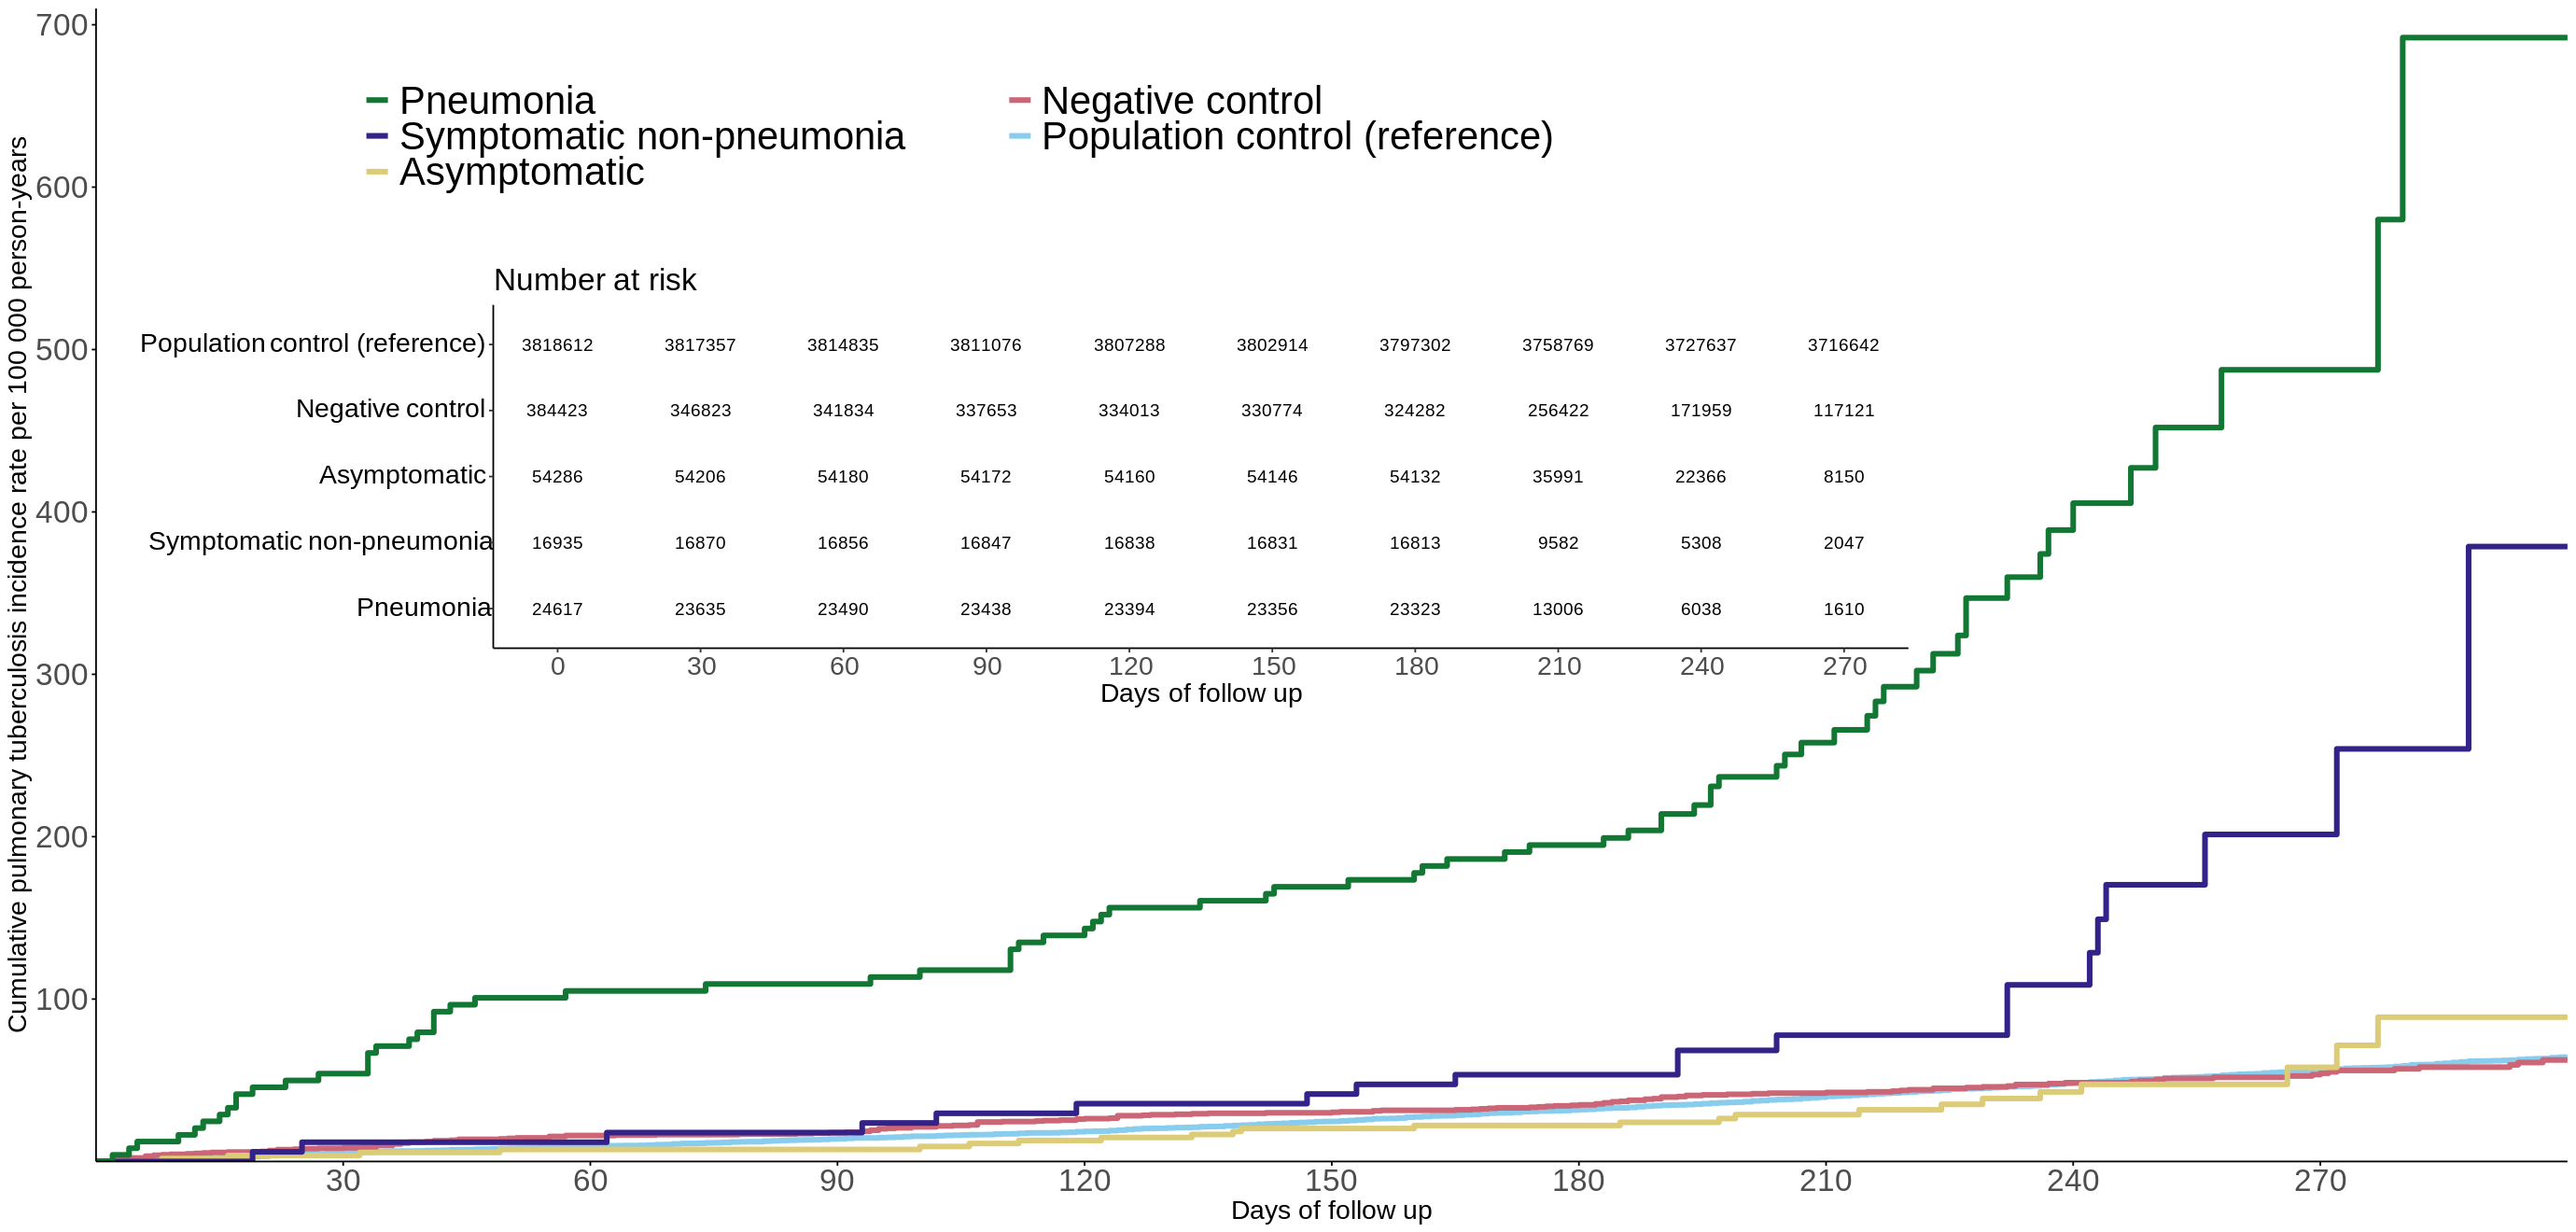

In [ ]:
options(repr.plot.width=23, repr.plot.height=11)
safe_colorblind_palette <- c("#88CCEE", "#CC6677", "#DDCC77","#332288", "#117733",  "#AA4499", 
                             "#44AA99", "#999933", "#882255", "#661100", "#6699CC", "#888888")
fit3 <- survfit(Surv(timetoevent, tb) ~ sevm, data = hhr)
fig3<-ggsurvplot(
  fit3,
  data = hhr,             # Add p-value
  fun ="cumhaz",
  censor = FALSE,
  palette = safe_colorblind_palette,
  legend.labs = c("Population control (reference)", 
                  "Negative control", "Asymptomatic", 
                  "Symptomatic non-pneumonia        ","Pneumonia"),
  risk.table = TRUE,
  risk.table.col = "black", risk.table.fontsize = 4,
  legend.title = "",
  size=1.7,
  surv.scale ="percent",
  break.time.by = 30,
  legend= c(0.35,0.9),
  ggtheme = theme_classic()      # Change ggplot2 theme
)
p3<-fig3$plot + guides(colour = guide_legend(nrow = 3,reverse = TRUE))+
  scale_x_continuous(name = "Days of follow up",breaks = 1:9*30,limits = c(0,300),expand = c(0,0))+
  scale_y_continuous(name= "Cumulative pulmonary tuberculosis incidence rate per 100 000 person-years",breaks = 1:7*0.001,limits = c(0,7*0.001+0.0001),labels = scales::label_number(scale = 1e5),expand = c(0,0))+
  theme(legend.text = element_text(size=25),
        legend.key = element_rect(fill = "transparent",colour ="transparent"),
        axis.text.x = element_text(size=20),
        axis.text.y = element_text(size=20),
        axis.title.x = element_text(size=17),
        axis.title.y = element_text(size=17))
fig3t<-ggsurvplot(
  fit3,
  data = hhr,             # Add p-value
  fun ="cumhaz",
  censor = FALSE,
  palette = c("black","black","black","black","black"),
  legend.labs = c("Population control (reference)", 
                  "Negative control", "Asymptomatic", 
                  "Symptomatic non-pneumonia","Pneumonia"),
  risk.table = TRUE,
  risk.table.col = "black", risk.table.fontsize = 4,
  legend.title = "",
  xlab="Days of follow up",
  size=1.7,
  surv.scale ="percent",
  xlim=c(0,270),
  break.time.by = 30,
  legend= c(0.15,0.9),
  ggtheme = theme_classic()      # Change ggplot2 theme
)
customize_labels <- function (p, font.title = NULL,
                              font.subtitle = NULL, font.caption = NULL,
                              font.x = NULL, font.y = NULL, font.xtickslab = NULL, font.ytickslab = NULL)
{
  original.p <- p
  if(is.ggplot(original.p)) list.plots <- list(original.p)
  else if(is.list(original.p)) list.plots <- original.p
  else stop("Can't handle an object of class ", class (original.p))
  .set_font <- function(font){
    font <- ggpubr:::.parse_font(font)
    ggtext::element_markdown (size = font$size, face = font$face, colour = font$color)
  }
  for(i in 1:length(list.plots)){
    p <- list.plots[[i]]
    if(is.ggplot(p)){
      if (!is.null(font.title)) p <- p + theme(plot.title = .set_font(font.title))
      if (!is.null(font.subtitle)) p <- p + theme(plot.subtitle = .set_font(font.subtitle))
      if (!is.null(font.caption)) p <- p + theme(plot.caption = .set_font(font.caption))
      if (!is.null(font.x)) p <- p + theme(axis.title.x = .set_font(font.x))
      if (!is.null(font.y)) p <- p + theme(axis.title.y = .set_font(font.y))
      if (!is.null(font.xtickslab)) p <- p + theme(axis.text.x = .set_font(font.xtickslab))
      if (!is.null(font.ytickslab)) p <- p + theme(axis.text.y = .set_font(font.ytickslab))
      list.plots[[i]] <- p
    }
  }
  if(is.ggplot(original.p)) list.plots[[1]]
  else list.plots
}
fig3t <- customize_labels(
  fig3t,
  font.title    = c(20 ),
  font.subtitle = c(17 ),
  font.caption  = c(17 ),
  font.x        = c(17 ),
  font.ytickslab = c(17),
  font.xtickslab = c(17)
)
transparent_theme <- theme(
  panel.background = element_rect(fill = "transparent",colour = NA),
  plot.background = element_rect(fill = "transparent",colour = NA),
  plot.margin=unit(c(0,0,0,0),"mm"),)
fig3tt<-fig3t$table+transparent_theme

p3 + annotation_custom(grob = ggplotGrob(fig3tt), xmin = 3,xmax = 220, 
                       ymin = 0.0028, ymax = 0.0055)

**Cox's regression**

We initially performed multiple Cox’s regression and check the assumption of proportional hazard.

In [ ]:
coxm <- coxph(Surv(timetoevent, tb) ~ sevm+sex+age+hiv+dm+cancer+copd, data = hhr)
summary(coxm)
cox.zph(coxm)

Call:
coxph(formula = Surv(timetoevent, tb) ~ sevm + sex + age + hiv + 
    dm + cancer + copd, data = hhr)

  n= 4298873, number of events= 2711 

                                 coef exp(coef) se(coef)      z Pr(>|z|)    
sevmNegative control          0.03587   1.03652  0.07974  0.450    0.653    
sevmAsymptomatic              0.30680   1.35907  0.21010  1.460    0.144    
sevmSymptomatic non-pneumonia 1.31826   3.73690  0.22502  5.858 4.68e-09 ***
sevmPneumonia                 2.01454   7.49726  0.11823 17.038  < 2e-16 ***
sexTRUE                       1.14903   3.15512  0.04326 26.562  < 2e-16 ***
age41-60                      0.38176   1.46486  0.04671  8.174 2.99e-16 ***
age>60                        0.42369   1.52758  0.05475  7.739 1.00e-14 ***
hivTRUE                       2.13346   8.44406  0.08798 24.251  < 2e-16 ***
dmTRUE                        0.91489   2.49651  0.05517 16.582  < 2e-16 ***
cancerTRUE                    0.71857   2.05150  0.09315  7.714 1.22e-14 ***
copdT

        chisq df       p
sevm   24.624  4 6.0e-05
sex     3.005  1  0.0830
age     0.273  2  0.8723
hiv     2.380  1  0.1229
dm      1.227  1  0.2681
cancer 10.244  1  0.0014
copd    6.410  1  0.0113
GLOBAL 49.816 11 6.8e-07

The model violated Cox's proportional hazard mainly due to sevm. Admission bias (Berkson's bias) lead to the surging of subsequent TB among patients with COVID-19. Therefore, we performed time-varying using time-spliting on the 30th day of follow up. The follow up period was divided into 2 groups: within 0–30 days of follow up and after that.

In [ ]:
hhr2 <- survSplit(Surv(timetoevent, tb) ~ ., data= hhr, cut=c(30),
                 episode= "tgroup", id="newid")

hhr2$sevm<-factor(hhr2$sevm,levels = c("Pneumonia","Symptomatic non-pneumonia",
                                     "Asymptomatic","Negative control","Population control"))
coxfit2 <- survival::coxph(Surv(tstart, timetoevent, tb) ~ sevm:strata(tgroup)+sex+age+hiv+dm+cancer+copd, data=hhr2)
summary(coxfit2)
cox.zph(coxfit2)

Warning message in agreg.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Ran out of iterations and did not converge”


Call:
survival::coxph(formula = Surv(tstart, timetoevent, tb) ~ sevm:strata(tgroup) + 
    sex + age + hiv + dm + cancer + copd, data = hhr2)

  n= 8557529, number of events= 2711 

                                                          coef exp(coef)
sexTRUE                                               1.149074  3.155269
age41-60                                              0.381758  1.464857
age>60                                                0.423628  1.527493
hivTRUE                                               2.133404  8.443557
dmTRUE                                                0.914801  2.496277
cancerTRUE                                            0.718435  2.051220
copdTRUE                                              0.932864  2.541777
sevmPneumonia:strata(tgroup)tgroup=1                  2.289948  9.874423
sevmSymptomatic non-pneumonia:strata(tgroup)tgroup=1  1.090657  2.976228
sevmAsymptomatic:strata(tgroup)tgroup=1              -0.004386  0.995623
sevmNegative co

                     chisq df       p
sex                  3.004  1 0.08307
age                  0.259  2 0.87836
hiv                  2.344  1 0.12578
dm                   1.122  1 0.28943
cancer              10.161  1 0.00143
copd                 6.267  1 0.01230
sevm:strata(tgroup) 31.452  8 0.00012
GLOBAL              56.605 15 9.6e-07

The model improved. However, we have to omit the remaining violation for simplicity.

*Calculate incidence*

In [ ]:
hhr$sevm<-factor(hhr$sevm,levels = c("Pneumonia","Symptomatic non-pneumonia",
                                     "Asymptomatic","Negative control","Population control"))
x1<-summary(pyears(Surv(timetoevent/365, tb) ~ sevm,data = hhr,scale = 1))
floor(x1$event/x1$pyears*100000)
r<-floor(x1$event/x1$pyears*100000)
se<-sqrt((1-r/100000)/x1$event)
lower<-floor(exp(log(r/100000)-qnorm(0.975)*se)*100000)
upper<-floor(exp(log(r/100000)+qnorm(0.975)*se)*100000)
x1f<-data.frame(inc=r,lower=lower,upper=upper)

x2<-summary(pyears(Surv(timetoevent/365, tb) ~ sevm,data = hhr2[hhr2$tgroup==1,],scale = 1))
floor(x2$event/x2$pyears*100000)
r<-floor(x2$event/x2$pyears*100000)
se<-sqrt((1-r/100000)/x2$event)
lower<-floor(exp(log(r/100000)-qnorm(0.975)*se)*100000)
upper<-floor(exp(log(r/100000)+qnorm(0.975)*se)*100000)
x2f<-data.frame(inc=r,lower=lower,upper=upper)
x2f

x3<-summary(pyears(Surv(timetoevent/365, tb) ~ sevm,data = hhr2[hhr2$tgroup==2,],scale = 1))
floor(x1$event/(x1$pyears-x2$pyears)*100000)
x1$pyears-x2$pyears
r<-floor(x3$event/(x1$pyears-x2$pyears)*100000)
se<-sqrt((1-r/100000)/x3$event)
lower<-floor(exp(log(r/100000)-qnorm(0.975)*se)*100000)
upper<-floor(exp(log(r/100000)+qnorm(0.975)*se)*100000)
x3f<-data.frame(inc=r,lower=lower,upper=upper)
x3f

x4<-summary(pyears(Surv(timetoevent/365, tb) ~ sex,data = hhr,scale = 1))
floor(x4$event/x4$pyears*100000)
r<-floor(x4$event/x4$pyears*100000)
se<-sqrt((1-r/100000)/x4$event)
lower<-floor(exp(log(r/100000)-qnorm(0.975)*se)*100000)
upper<-floor(exp(log(r/100000)+qnorm(0.975)*se)*100000)
x4f<-data.frame(inc=r,lower=lower,upper=upper)
x4f

x5<-summary(pyears(Surv(timetoevent/365, tb) ~ age,data = hhr,scale = 1))
r<-floor(x5$event/x5$pyears*100000)
se<-sqrt((1-r/100000)/x5$event)
lower<-floor(exp(log(r/100000)-qnorm(0.975)*se)*100000)
upper<-floor(exp(log(r/100000)+qnorm(0.975)*se)*100000)
x5f<-data.frame(inc=r,lower=lower,upper=upper)
x5f

x6<-summary(pyears(Surv(timetoevent/365, tb) ~ hiv,data = hhr,scale = 1))
r<-floor(x6$event/x6$pyears*100000)
se<-sqrt((1-r/100000)/x6$event)
lower<-floor(exp(log(r/100000)-qnorm(0.975)*se)*100000)
upper<-floor(exp(log(r/100000)+qnorm(0.975)*se)*100000)
x6f<-data.frame(inc=r,lower=lower,upper=upper)
x6f

x7<-summary(pyears(Surv(timetoevent/365, tb) ~ dm,data = hhr,scale = 1))
r<-floor(x7$event/x7$pyears*100000)
se<-sqrt((1-r/100000)/x7$event)
lower<-floor(exp(log(r/100000)-qnorm(0.975)*se)*100000)
upper<-floor(exp(log(r/100000)+qnorm(0.975)*se)*100000)
x7f<-data.frame(inc=r,lower=lower,upper=upper)
x7f

x8<-summary(pyears(Surv(timetoevent/365, tb) ~ copd,data = hhr,scale = 1))
r<-floor(x8$event/x8$pyears*100000)
se<-sqrt((1-r/100000)/x8$event)
lower<-floor(exp(log(r/100000)-qnorm(0.975)*se)*100000)
upper<-floor(exp(log(r/100000)+qnorm(0.975)*se)*100000)
x8f<-data.frame(inc=r,lower=lower,upper=upper)
x8f

x9<-summary(pyears(Surv(timetoevent/365, tb) ~ cancer,data = hhr,scale = 1))
r<-floor(x9$event/x9$pyears*100000)
se<-sqrt((1-r/100000)/x9$event)
lower<-floor(exp(log(r/100000)-qnorm(0.975)*se)*100000)
upper<-floor(exp(log(r/100000)+qnorm(0.975)*se)*100000)
x9f<-data.frame(inc=r,lower=lower,upper=upper)
x9f

Call: pyears(formula = Surv(timetoevent/365, tb) ~ sevm, data = hhr, 
    scale = 1)

number of observations = 4298873

           sevm                 N      Events      Time     
--------------------------- --------- -------- ------------ 
         Pneumonia             24617      75      14159.64 
 Symptomatic non-pneumonia     16935      20      10325.18 
       Asymptomatic            54286      23      34251.42 
     Negative control         384423     170     227917.62 
    Population control       3818612    2423    3108224.16 


sevm
                Pneumonia Symptomatic non-pneumonia              Asymptomatic 
                      529                       193                        67 
         Negative control        Population control 
                       74                        77

Call: pyears(formula = Surv(timetoevent/365, tb) ~ sevm, data = hhr2[hhr2$tgroup == 
    1, ], scale = 1)

number of observations = 4298873

           sevm                 N      Events      Time     
--------------------------- --------- -------- ------------ 
         Pneumonia             24617     13       1972.838 
 Symptomatic non-pneumonia     16935      2       1388.792 
       Asymptomatic            54286      2       4457.997 
     Negative control         384423     30      29026.085 
    Population control       3818612    208     313812.745 


sevm
                Pneumonia Symptomatic non-pneumonia              Asymptomatic 
                      658                       144                        44 
         Negative control        Population control 
                      103                        66

,inc,lower,upper
,<dbl>,<dbl>,<dbl>
Pneumonia,658,382,1131
Symptomatic non-pneumonia,144,36,575
Asymptomatic,44,11,175
Negative control,103,72,147
Population control,66,57,75


Call: pyears(formula = Surv(timetoevent/365, tb) ~ sevm, data = hhr2[hhr2$tgroup == 
    2, ], scale = 1)

number of observations = 4258656

           sevm                 N      Events      Time     
--------------------------- --------- -------- ------------ 
         Pneumonia             23620      62      14128.17 
 Symptomatic non-pneumonia     16869      18      10322.88 
       Asymptomatic            54204      21      34248.55 
     Negative control         346655     140     227383.73 
    Population control       3817308    2215    3108162.75 


sevm
                Pneumonia Symptomatic non-pneumonia              Asymptomatic 
                      615                       223                        77 
         Negative control        Population control 
                       85                        86

sevm
                Pneumonia Symptomatic non-pneumonia              Asymptomatic 
                12186.803                  8936.392                 29793.422 
         Negative control        Population control 
               198891.537               2794411.411

,inc,lower,upper
,<dbl>,<dbl>,<dbl>
Pneumonia,508,396,651
Symptomatic non-pneumonia,201,126,318
Asymptomatic,70,45,107
Negative control,70,59,82
Population control,79,75,82


Call: pyears(formula = Surv(timetoevent/365, tb) ~ sex, data = hhr, 
    scale = 1)

number of observations = 4298873

  sex       N      Events    Time    
------- --------- -------- --------- 
 FALSE   2332323     749    1836778 
 TRUE    1966550    1962    1558100 


sex
FALSE  TRUE 
   40   125

Call: pyears(formula = Surv(timetoevent/365, tb) ~ age, data = hhr, 
    scale = 1)

number of observations = 4298873

  age       N      Events    Time    
------- --------- -------- --------- 
 18-40   2011742     865    1580209 
 41-60   1435601    1075    1136834 
  >60     851530     771     677835 


,inc,lower,upper
,<dbl>,<dbl>,<dbl>
18-40,54,50,57
41-60,94,88,99
>60,113,105,121


Call: pyears(formula = Surv(timetoevent/365, tb) ~ hiv, data = hhr, 
    scale = 1)

number of observations = 4298873

  hiv       N      Events      Time     
------- --------- -------- ------------ 
 FALSE   4274497    2572    3375716.75 
 TRUE      24376     139      19161.27 


,inc,lower,upper
,<dbl>,<dbl>,<dbl>
FALSE,76,73,78
TRUE,725,614,855


Call: pyears(formula = Surv(timetoevent/365, tb) ~ dm, data = hhr, 
    scale = 1)

number of observations = 4298873

  dm        N      Events     Time     
------- --------- -------- ----------- 
 FALSE   4021712    2261    3178673.8 
 TRUE     277161     450     216204.2 


,inc,lower,upper
,<dbl>,<dbl>,<dbl>
FALSE,71,68,73
TRUE,208,189,228


Call: pyears(formula = Surv(timetoevent/365, tb) ~ copd, data = hhr, 
    scale = 1)

number of observations = 4298873

 copd       N      Events      Time     
------- --------- -------- ------------ 
 FALSE   4247235    2569    3354787.54 
 TRUE      51638     142      40090.48 


,inc,lower,upper
,<dbl>,<dbl>,<dbl>
FALSE,76,73,78
TRUE,354,300,417


Call: pyears(formula = Surv(timetoevent/365, tb) ~ cancer, data = hhr, 
    scale = 1)

number of observations = 4298873

 cancer      N      Events      Time     
-------- --------- -------- ------------ 
 FALSE    4220062    2586    3332890.38 
  TRUE      78811     125      61987.64 


,inc,lower,upper
,<dbl>,<dbl>,<dbl>
FALSE,77,74,80
TRUE,201,168,239
